In [7]:
import pickle
import copy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from experiments import *
from utils import *

In [8]:
1+1

2

In [9]:
splits = ['iid','noniid']
benchs = ['lb','mmlu','helm','alpaca']

In [10]:
#style = {"alpha":.25, "linewidth":1.25, "markeredgewidth":1, "elinewidth":1.5, "capsize":3, "linestyle":''}
style = {"alpha":1, "markersize":3, "markeredgewidth":1, "elinewidth":1, "capsize":3, "linestyle":''}

def plot_perf_lines(table_avg, table_std, title, xlabel, ylabel, ylim, legend=False, error_bar=False):
    markers = ['o', 'v', '*', 'x', 's','p']
    jitters = [6.3,3.7,1.3,-1.3,-3.7,-6.3]
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:9]
    j=0
    for method, values in table_avg.items():
        x = np.array(list(values.keys()))
        y = np.array(list(values.values()))
        s = np.array(list(table_std[method].values()))
        
        if error_bar: 
            plt.errorbar(x+jitters[j], y, color=colors[j], yerr=s, label=method, marker=markers[j], **style)
        else: 
            plt.plot(x, y, label=method)

        j+=1
    plt.xlabel(xlabel)
    if i==0:plt.ylabel(ylabel)
    plt.ylim(ylim[0], ylim[1])
    plt.title(title)
    if legend: plt.legend(loc='upper center', ncols=6, bbox_to_anchor=(-1.5, -.25))
    plt.grid(alpha=.2)
    #plt.grid(which='major', color='black', linestyle='-')
    #plt.grid(which='minor', color='gray', linestyle=':')
    #plt.show()

In [11]:
def winrate(x,axis):
    n = x.shape[axis]
    return(np.argsort(np.argsort(x, axis=axis), axis=axis)/n)

def load_scores(bench, split):
    with open(f'results/accs_{bench}_split-{split}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    
    if bench=='mmlu':
        with open(f'data/lb.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    elif bench=='alpaca':
        with open(f'data/alpaca_v2_processed.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    else:
        with open(f'data/{bench}.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    if bench=='lb':scenarios = lb_scenarios
    elif bench=='mmlu':scenarios = {'mmlu':lb_scenarios['mmlu']}
    elif bench=='helm':scenarios = helm_scenarios
    elif bench=='alpaca':scenarios = alpaca_scenarios
    elif bench=='mmlu_fields':scenarios = {'mmlu':lb_scenarios['mmlu']}
    else: raise NotImplementedError
    
    scenarios_position, subscenarios_position = prepare_data(scenarios, scenarios, data2)
    scores = create_responses(scenarios, scenarios, data2)
        
    balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
    if 'civil_comments' in scenarios:
        balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
        scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)
    if 'mmlu' in scenarios:
        N = len(scenarios_position['mmlu'])
        n_sub = len(scenarios['mmlu'])
        for sub in scenarios['mmlu']:
            n_i = len(subscenarios_position['mmlu'][sub])
            balance_weights[subscenarios_position['mmlu'][sub]] = N/(n_sub*n_i)
    scores = balance_weights*scores
    
    scores = np.vstack([scores[:,scenarios_position[scenario]].mean(axis=1) for scenario in scenarios])
    
    return scores[:,list(data.keys())]

In [12]:
methods = ['random_naive', 'anchor_naive', 'anchor-irt_naive', #'anchor-irt_gpirt']
           #'random_pirt', 'anchor_pirt', 'anchor-irt_pirt']#,
           #'random_cirt','anchor_cirt', 'anchor-irt_cirt']#,
           'random_gpirt', 'anchor_gpirt', 'anchor-irt_gpirt']

In [13]:
table_avg = {}
table_std = {}

In [14]:
titles = {'lb':'LLM Leaderboard','mmlu':'MMLU','helm':'HELM','alpaca':'AlpacaEval'}
ylims = {'lb':(0,.04),'helm':(0,.1),'mmlu':(0,.1),'alpaca':(0,.1)}

In [15]:
result = 'results'

In [16]:
bench='lb'
splits

['iid', 'noniid']

for bench in ['lb']:
    table_avg[bench] = {}
    table_std[bench] = {}
        
    for split in splits:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        
        with open(f'results/accs_{bench}_split-{split}_iterations-5.pickle', 'rb') as handle:
            data = pickle.load(handle)
        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        iterations = data[models[0]][number_items[0]][methods[0]][scenarios[0]]
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)
        
        for s,scenario in enumerate(scenarios):
            print(bench,split,s,scenario)
            table_avg[bench][split][scenario] = {}
            table_std[bench][split][scenario] = {}
                
            
            with open(f'results/accs_{bench}_split-{split}.pickle', 'rb') as handle:
                data = pickle.load(handle)
            models = list(data.keys())
            number_items = list(data[models[0]].keys())
            scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
            iterations = data[models[0]][number_items[0]][methods[0]][scenarios[0]]
            data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
            scores = load_scores(bench, split)
            
        
            print(data.shape, scores.T.shape)
            data = np.abs(data-scores.T[None,None,:,:,None])[:,:,:,s,:]
            data = data.mean(-1) #iterations

            for i,method in enumerate(methods):
                table_avg[bench][split][scenario][method] = {}
                table_std[bench][split][scenario][method] = {}

                for j,number_item in enumerate(number_items):
                    table_avg[bench][split][scenario][method][number_item] = np.mean(data, axis=-1)[i,j]
                    table_std[bench][split][scenario][method][number_item] = data.std(-1)[i,j]

for split in splits:
    # Create a figure and a set of subplots
    plt.figure(figsize=(25,3))

    # Iterate over your benchmarks
    for i,scenario in enumerate(scenarios):  # Replace `benchmarks` with your list of benchmarks
        # Plot on the ith subplot
        plt.subplot(1, 6, i+1)
        plot_perf_lines(table_avg[bench][split][scenario], table_std[bench][split][scenario],
                        title=scenarios[i],
                        xlabel='number of items (per scenario)',
                        ylabel='avg performance estimation error', ylim=(0,.1), legend=i+1==4,error_bar=True)#ylims[bench]

        
    plt.suptitle(split)
    # Adjust layout
    #plt.tight_layout()

    # Display the plot
    plt.show()

In [17]:
benchs = ['lb', 'mmlu', 'helm', 'alpaca','mmlu_fields']

In [18]:
agg = 'leaderboard'
results = 'acc'
agg_metric = 'avg' #'std'

In [19]:
table_avg = {}
table_std = {}
model_perf = {}
for bench in benchs:
    table_avg[bench] = {}
    table_std[bench] = {}
    model_perf[bench] = {}
        
    for split in splits:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        model_perf[bench][split] = {}

        with open(f'results/accs_{bench}_split-{split}_iterations-10.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        #iterations = data[models[0]][number_items[0]][methods[0]][scenarios[0]]
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)
        
        if agg == 'leaderboard':
            if bench=='helm': 
                ###
                model_perf[bench][split]['truth'] = winrate(scores, axis=1).mean(axis=0)
                for i,method in enumerate(methods):
                    model_perf[bench][split][method] = {}
                    model_perf[bench][split][method] = {}
                    for j,number_item in enumerate(number_items):
                        model_perf[bench][split][method][number_item] = winrate(data, axis=2).mean(axis=3)[i,j,:,:]
                ###
                data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
            else: 
                ###
                model_perf[bench][split]['truth'] = scores.mean(axis=0)
                for i,method in enumerate(methods):
                    model_perf[bench][split][method] = {}
                    model_perf[bench][split][method] = {}
                    for j,number_item in enumerate(number_items):
                        model_perf[bench][split][method][number_item] = data.mean(axis=3)[i,j,:,:]
                ###
                data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
        elif agg == 'scenarios':
            if results == 'acc': 
                data = np.abs(data-scores.T[None,None,:,:,None]).mean(axis=3)
            elif results == 'rank': 
                rank_corrs = np.zeros(data.mean(axis=2).shape)
                for i in range(rank_corrs.shape[0]):
                    for j in range(rank_corrs.shape[1]):
                        for k in range(rank_corrs.shape[2]):
                            for l in range(rank_corrs.shape[3]):
                                rank_corrs[i,j,k,l] = stats.spearmanr(data[i,j,:,k,l], scores.T[:,k]).statistic
                data=rank_corrs
            else: 
                raise NotImplementedError
        else:
            raise NotImplementedError
            
        if agg_metric=='avg':
            data = data.mean(-1) #iterations
        elif agg_metric=='std':
            data = data.std(-1)
        else:
            raise NotImplementedError
            
        
        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                table_avg[bench][split][method][number_item] = np.mean(data, axis=-1)[i,j]
                table_std[bench][split][method][number_item] = data.std(-1)[i,j]

FileNotFoundError: [Errno 2] No such file or directory: 'results/accs_lb_split-iid_iterations-10.pickle'

variation across seeds

In [ ]:
if agg == 'leaderboard':
    split = 'noniid'
    iteration = 0
    number_item = 100

    alphas = {'random_naive':.2,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.5}
    markersize = {'random_naive':5,'anchor_naive':4,'anchor-irt_naive':4,'anchor-irt_gpirt':3}
    names = {'random_naive':'random','anchor-irt_naive':'anchor-IRT ','anchor_naive':'anchor ','anchor-irt_gpirt':'gp-IRT  '}
    plt.figure(figsize=(6.15,5.5))

    if agg == 'leaderboard':
        for i,bench in enumerate(benchs[:4]): #benchs[:4]
            plt.subplot(2, 2, i+1)
            axis = {'lb':'avg. score', 'mmlu':'score', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.3f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method])
                #plt.plot(model_perf[bench][split][method][number_item][:,0],model_perf[bench][split][method][number_item][:,iteration],'o',markersize=3,alpha=.5)
            plt.legend(fontsize=7)
            plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.1)
            plt.xlabel('true '+axis[bench])
            plt.ylabel('predicted '+axis[bench])
            plt.xlim(0,1)
            plt.ylim(0,1)

        plt.tight_layout()
        plt.show()

In [40]:
model_perf[bench][split].keys()

dict_keys([])

In [41]:
if results == 'acc': ylim = (0,.1)
elif results == 'rank': 
    if agg_metric == 'std':
        ylim = (0,.1)
    else:
        ylim = (.5,1)
else: raise NotImplementedError

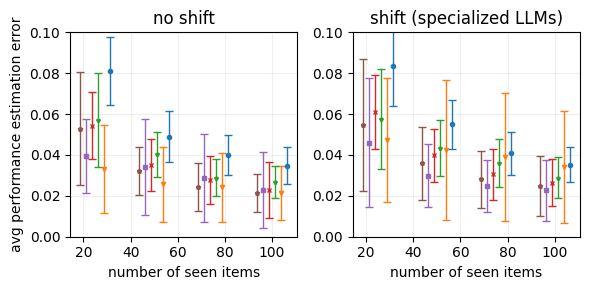

In [42]:
plt.figure(figsize=(6,3))
bench='mmlu_fields'
# Iterate over your benchmarks
for i, split in enumerate(splits):  # Replace `benchmarks` with your list of benchmarks
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                    title={'iid':'no shift', 'noniid':'shift (specialized LLMs)'}[split],
                    xlabel='number of seen items',
                    ylabel='avg performance estimation error', ylim=ylim, legend=False, error_bar=True)
    plt.tight_layout()
plt.show()

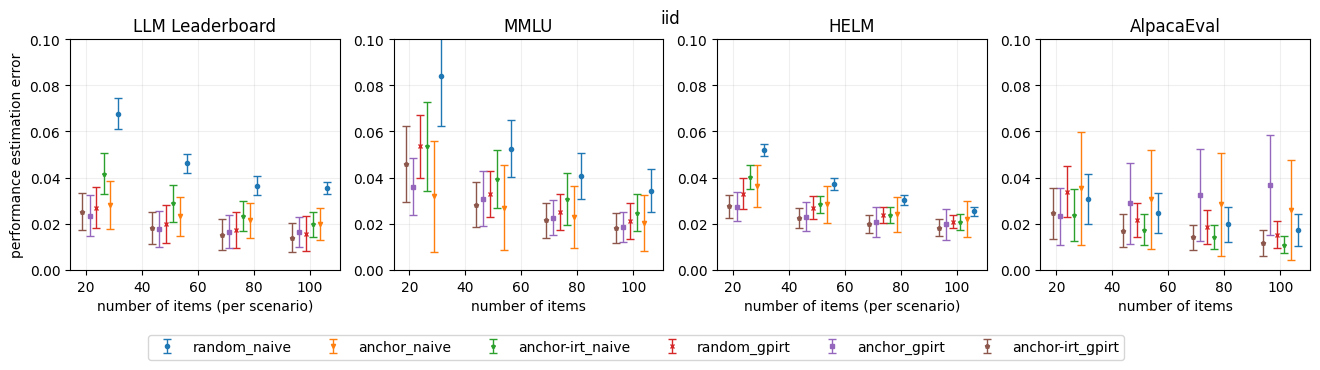

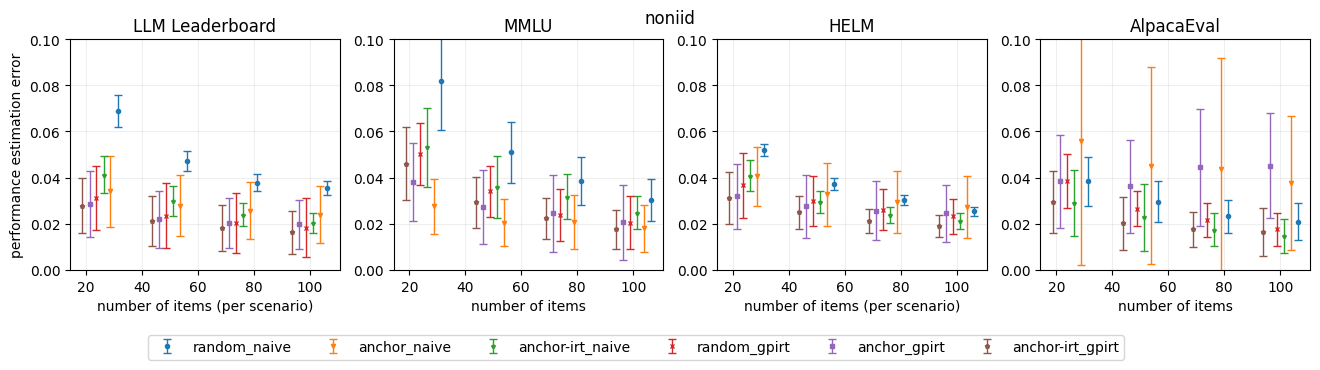

In [43]:
for split in splits:
    # Create a figure and a set of subplots
    plt.figure(figsize=(16,3))

    if result == 'results': ylabel='performance estimation error'
    else: ylabel = 'avg. performance estimation error'
 
    # Iterate over your benchmarks
    for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
        if bench in ['mmlu','alpaca']: xlabel='number of items'
        else: xlabel='number of items (per scenario)'    
        # Plot on the ith subplot
        plt.subplot(1, 4, i+1)
        plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                        title=titles[bench],
                        xlabel=xlabel,
                        ylabel=ylabel, ylim=ylim, legend=i+1==4,error_bar=True)#ylims[bench]

    plt.suptitle(split)
    # Adjust layout
    #plt.tight_layout()

    # Display the plot
    plt.show()

In [2]:
with open('results/samples_mmlu.pickle', 'rb') as handle:
    sample_data = pickle.load(handle)

In [3]:
iteration = 1
number_item = 100

In [4]:
sample_data['A'].shape

(1, 10, 14042)

In [6]:
np.vstack((sample_data['A'].squeeze(), sample_data['B'].reshape((1,-1)))).shape

(11, 14042)

In [50]:
E = sample_data['A'].squeeze() #np.hstack((sample_data['A'], sample_data['B'])).squeeze()

In [51]:
w = sample_data['item_weights']['anchor-irt'][number_item][iteration]['mmlu']

1/(w.shape[0]*np.sum((w)**2)), w.max()

(0.9165910170507191, 0.0206353067689662)

In [52]:
with open('data/lb.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
#scenarios
scenarios = lb_scenarios
scenarios = {'mmlu':scenarios['mmlu']}
chosen_scenarios = ['mmlu']

In [53]:
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
#scores = create_responses(chosen_scenarios, scenarios, data)

In [62]:
points_per_sub = {'sub':scenarios['mmlu']}

for it in range(len(sample_data['seen_items']['anchor-irt'][number_item])):
    seen_data = sample_data['seen_items']['anchor-irt'][number_item][it]
    points_per_sub['n_'+str(it)]=[np.sum([True for s in seen_data if s in subscenarios_position['mmlu'][sub]]) for sub in scenarios['mmlu']]

In [63]:
df = pd.DataFrame(points_per_sub)

In [64]:
df['n_avg'] = df.iloc[:,1:].mean(axis=1)
df['n_std'] = df.iloc[:,1:].std(axis=1)

In [65]:
df.sort_values(by=['n_avg'], ascending=False)

,sub,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_avg,n_std
48,harness_hendrycksTest_professional_law_5,4.0,7.0,6.0,8.0,9.0,9.0,8.0,7.0,8.0,8.0,7.4,1.428286
41,harness_hendrycksTest_miscellaneous_5,7.0,4.0,8.0,5.0,6.0,6.0,7.0,5.0,6.0,4.0,5.8,1.249000
43,harness_hendrycksTest_moral_scenarios_5,5.0,7.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.1,0.700000
52,harness_hendrycksTest_security_studies_5,8.0,4.0,2.0,6.0,2.0,6.0,2.0,5.0,1.0,2.0,3.8,2.227106
4,harness_hendrycksTest_clinical_knowledge_5,4.0,5.0,1.0,5.0,6.0,3.0,2.0,2.0,1.0,4.0,3.3,1.676305
45,harness_hendrycksTest_philosophy_5,3.0,3.0,3.0,3.0,4.0,2.0,4.0,2.0,4.0,4.0,3.2,0.748331
26,harness_hendrycksTest_high_school_microeconomi...,2.0,3.0,4.0,4.0,5.0,3.0,0.0,1.0,3.0,5.0,3.0,1.549193
50,harness_hendrycksTest_professional_psychology_5,0.0,6.0,3.0,3.0,3.0,1.0,4.0,4.0,1.0,3.0,2.8,1.661325
29,harness_hendrycksTest_high_school_statistics_5,1.0,4.0,2.0,3.0,1.0,3.0,4.0,3.0,3.0,2.0,2.6,1.019804
36,harness_hendrycksTest_logical_fallacies_5,3.0,4.0,2.0,2.0,0.0,4.0,3.0,2.0,3.0,3.0,2.6,1.113553


In [218]:
subs = list(subscenarios_position['mmlu'].keys())

In [219]:
from sklearn.cluster import KMeans 
from sklearn.metrics import  silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances


In [220]:
E = E.T#[:y.shape[0]]
scaled_E = StandardScaler().fit_transform(E)
E.shape

(14042, 10)

In [226]:
D = -np.ones((len(subs),len(subs)))
1

1

In [230]:
for i in tqdm(range(len(subs))):
    for j in range(len(subs)):
        X = E[subscenarios_position['mmlu'][subs[i]]].mean(axis=0)
        Y = E[subscenarios_position['mmlu'][subs[j]]].mean(axis=0)
        D[i,j] = np.sqrt(((X-Y)**2).sum())
        #D[i,j] = pairwise_distances(X, Y, metric='euclidean').mean()

100%|█████████████████████████████████████████████████████| 57/57 [00:08<00:00,  6.85it/s]


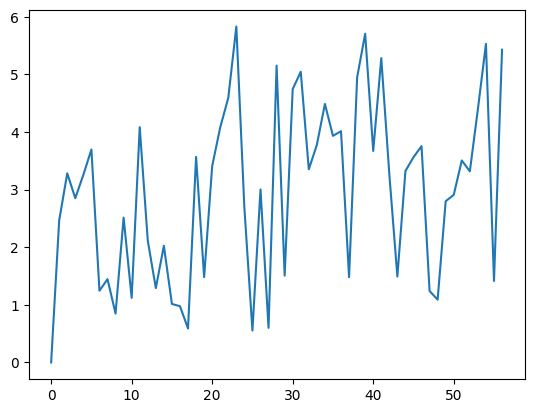

In [231]:
plt.plot(D[0])

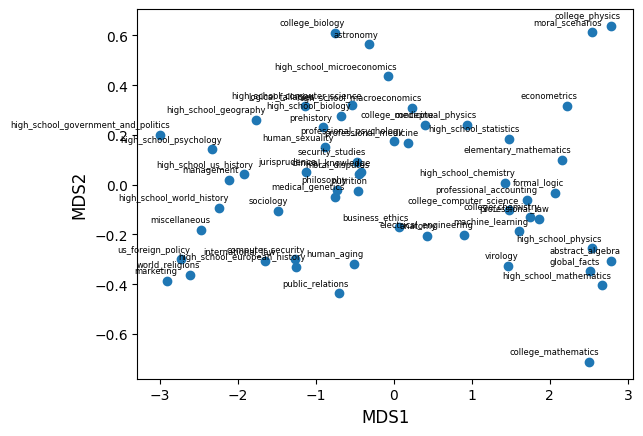

In [233]:
#Transforming D
n=D.shape[0]
e=np.ones(n).reshape((-1,1))
P=np.diag(e.squeeze())-e@e.T/n
M=-(P@D**2@P)/2

#
V, U=np.linalg.eigh(M)
V=np.sqrt(np.array(V[::-1])[:2])
U=np.array(U[:,::-1])[:,:2]

plt.scatter(V[0]*U[:,0], V[1]*U[:,1])
for i in range(n):
    plt.annotate(subs[i][22:-2], xy=(V[0]*U[:,0][i], V[1]*U[:,1][i]), xytext=(7, 4), fontsize = 6,
                 textcoords='offset points', ha='right', va='bottom')
    
plt.xlabel('MDS1', size=12)
plt.ylabel('MDS2', size=12)
plt.show()

  0%|                                                               | 0/8 [00:00<?, ?it/s]

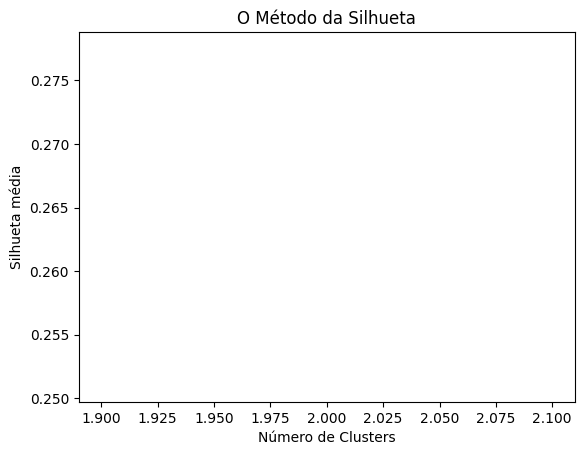

 12%|██████▉                                                | 1/8 [00:52<06:06, 52.40s/it]

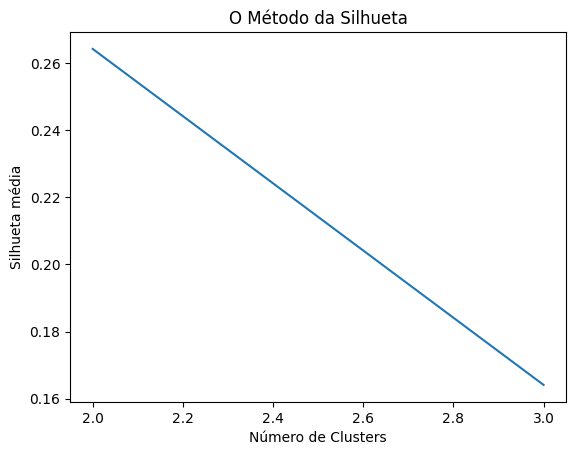

 25%|█████████████▊                                         | 2/8 [01:28<04:16, 42.71s/it]

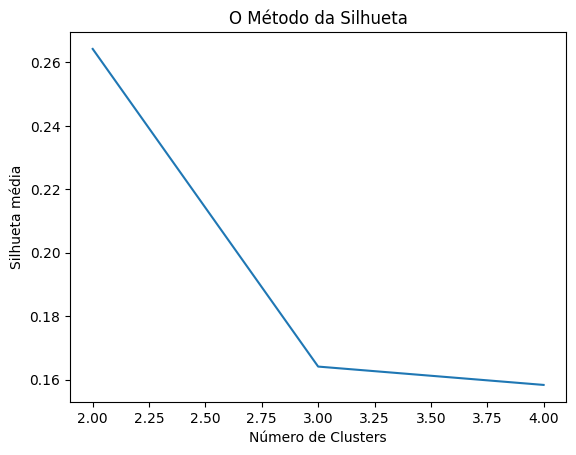

 38%|████████████████████▋                                  | 3/8 [02:26<04:08, 49.71s/it]

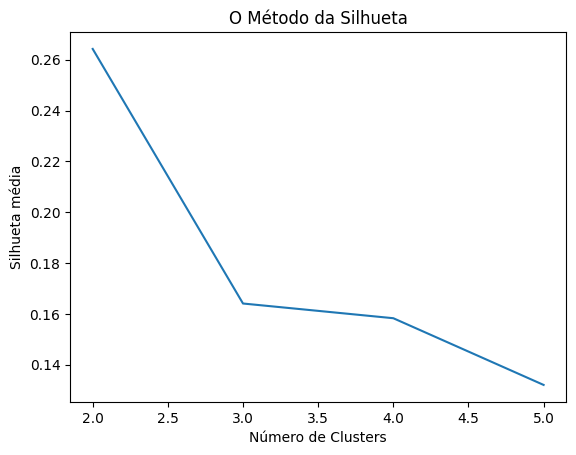

 50%|███████████████████████████▌                           | 4/8 [03:10<03:09, 47.33s/it]

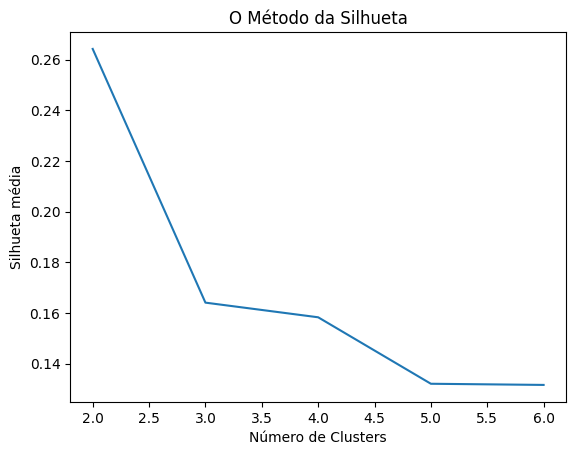

 62%|██████████████████████████████████▍                    | 5/8 [04:17<02:43, 54.61s/it]

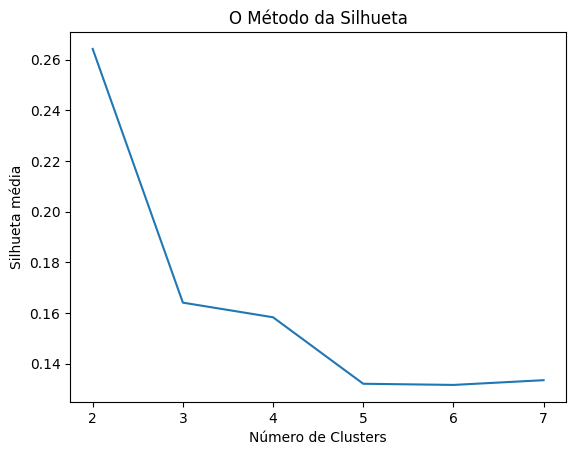

 75%|█████████████████████████████████████████▎             | 6/8 [05:00<01:41, 50.56s/it]

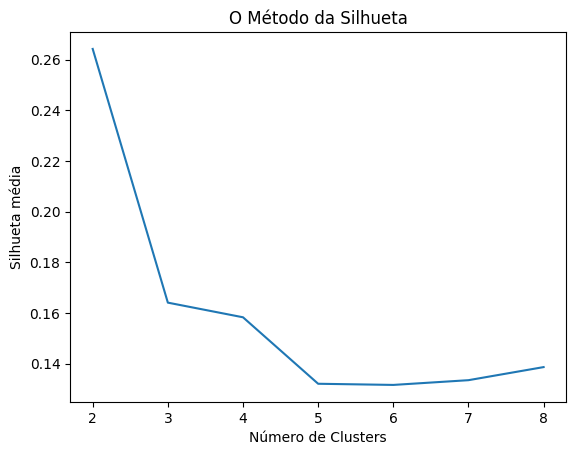

 88%|████████████████████████████████████████████████▏      | 7/8 [05:53<00:51, 51.39s/it]

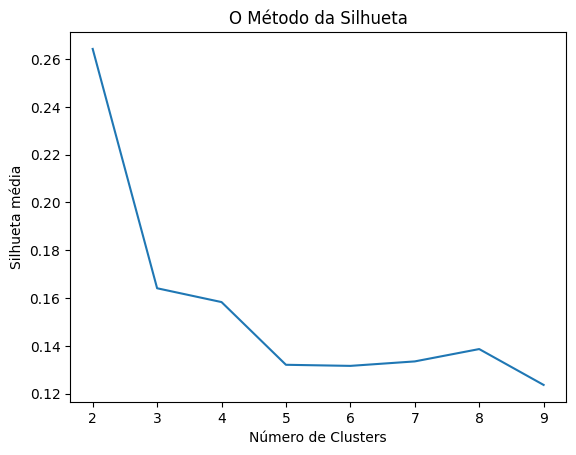

100%|███████████████████████████████████████████████████████| 8/8 [06:32<00:00, 49.01s/it]


In [70]:
sill = []

for i in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters = i, random_state=0, n_init='auto', verbose=0)
    kmeans.fit(E)
    cluster_labels = kmeans.predict(E)

    sill.append(silhouette_score(E, cluster_labels))
    
    plt.plot(range(2, 2+i-1), sill)
    plt.title('O Método da Silhueta')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhueta média') 
    plt.show()

In [ ]:
y=[]
for i,sub in enumerate(subs):
    y+=len(subscenarios_position['mmlu'][sub])*[i]
    
y = np.array(y)
y.shape

In [ ]:
reordered_E = []
for i,sub in enumerate(subs):
    reordered_E.append(E[subscenarios_position['mmlu'][sub]])

In [ ]:
reordered_E = np.vstack(reordered_E)
reordered_E.shape

In [ ]:
#!pip install umap-learn
import umap

import umap.plot

In [ ]:
%%time
reducer = umap.UMAP(verbose=True, repulsion_strength=1)
manifold = umap.UMAP().fit(scaled_E, y)

In [ ]:
umap.plot.points(manifold, labels=y)

In [ ]:
umap.plot.points(manifold, labels=y, theme="fire")

In [ ]:
umap.plot.points(manifold, labels=y, color_key_cmap='Paired', background='black')

In [ ]:
%%time
reducer = umap.UMAP(verbose=True, repulsion_strength=1)
manifold = umap.UMAP().fit(reordered_E, y)

In [ ]:
umap.plot.points(manifold, labels=y, background='black')

In [ ]:
umap.plot.points(manifold, labels=y, theme="fire")

In [ ]:
umap.plot.points(manifold, labels=y, color_key_cmap='Paired', background='black')

In [ ]:
umap.plot.connectivity(manifold, edge_bundling='hammer')